<a href="https://colab.research.google.com/github/hyxxnii/NLP-Practice/blob/master/RNN%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EB%B6%84%EB%A5%98/1.%EC%8A%A4%ED%8C%B8%20%EB%A9%94%EC%9D%BC%20%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0(Spam%20Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://wikidocs.net/22894

데이터 다운로드 링크: https://www.kaggle.com/uciml/sms-spam-collection-dataset

## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

In [3]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


- v1: 스팸인지 아닌지
  - ham: 정상메일
  - spam: 스팸 메일
- v2: 메일의 본문

v1, v2 변수만 필요하므로 나머지는 제거

In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'], [0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [7]:
data.isnull().values.any()

False

In [8]:
data['v2'].nunique(), data['v1'].nunique()

# 총 5571개의 데이터 중 v2 변수에 중복 샘플이 존재

(5169, 2)

In [9]:
# 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


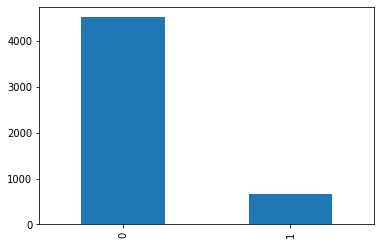

In [10]:
data['v1'].value_counts().plot(kind='bar');
# 클래스 불균형 데이터 (대부분 정상 메일)

In [11]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [13]:
# 데이터 분리
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [17]:
# 토큰화와 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [ ]:
# 각 정수에 어떤 단어가 부여되어 있는지 확인
word_to_index = tokenizer.word_index
print(word_to_index)

(출력셀 생략)

'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10

In [ ]:
# 각 단어에 대한 등장 빈도수
tokenizer.word_counts.items()

In [24]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


등장 빈도가 threshold 값인 2회 미만이다. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다.

하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않는다.

만약 등장 빈도가 지나치게 낮은 단어들은 일전에 제외하고 싶아면 케라스 토크나이저 선언 시에 지정해주면 됨

- `tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)`


In [25]:
# 이번 실습에선 단어 집합 크기를 제한하지 않고 진행
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8921


In [26]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :', n_of_train)
print('테스트 데이터의 개수:', n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


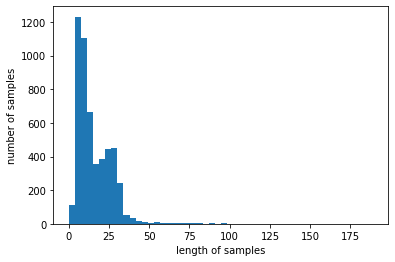

In [27]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

전체 데이터의 길이 분포는 대체적으로 약 50이하

In [28]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춤
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


In [29]:
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장

## 2. RNN으로 스팸 메일 분류하기

Vanila RNN을 이용하여 스팸 메일 분류기를 만들어보자

In [31]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 4s 53ms/step - loss: 0.3195 - acc: 0.8945 - val_loss: 0.2643 - val_acc: 0.8972
Epoch 2/4
52/52 [==============================] - 3s 49ms/step - loss: 0.1155 - acc: 0.9698 - val_loss: 0.0842 - val_acc: 0.9794
Epoch 3/4
52/52 [==============================] - 2s 47ms/step - loss: 0.0717 - acc: 0.9819 - val_loss: 0.0593 - val_acc: 0.9831
Epoch 4/4
52/52 [==============================] - 2s 48ms/step - loss: 0.0448 - acc: 0.9888 - val_loss: 0.0816 - val_acc: 0.9807


validation_split=0.2을 주어서 훈련 데이터의 20%를 검증 데이터로 나누고, 검증 데이터를 보면서 훈련이 제대로 되고 있는지 확인해본다. 

이때 검증 데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은지 확인하기 위한 용도로 사용됨

In [32]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 12ms/step - loss: 0.0982 - acc: 0.9758

 테스트 정확도: 0.9758


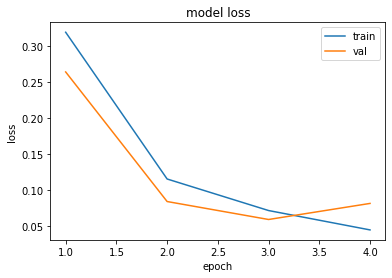

In [35]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

이번 실습 데이터는 데이터의 양이 적어 과적합이 빠르게 시작되므로, 검증 데이터에 대한 오차가 증가하기 시작하는 시점의 바로 직전인 에포크 3 정도가 적당한 것 같다.